<h1><center>Práctica Donativos Veterano de Guerra<center><h1>

# Integrantes

Sofía Maceín Sanz, María Araceli Pérez Buendía.

Fecha de entrega: 23 de febrero de 2024

# 0. Librerías

In [1]:
# Paquetes y librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

from scipy import stats
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!pip install graphviz


En primer lugar, obtenemos los datos del análisis exploratorio hecho previamente, habiendo separado los datos en un conjunto de entrenamiento y de test.

In [3]:
# Importacion de datos
X_train = pd.read_csv('./Datos/X_train.csv')
X_val = pd.read_csv('./Datos/X_val.csv')
X_test = pd.read_csv('./Datos/X_test.csv')
y_train = pd.read_csv('./Datos/y_train.csv')
y_val = pd.read_csv('./Datos/y_val.csv')
y_test = pd.read_csv('./Datos/y_test.csv')

## Funciones auxiliares

In [4]:
# Funcion para crear el modelo 
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

# Funcion para mostrar los resultados
def mostrar_resultados2(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels='x', yticklabels='y', annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    
    print(classification_report(y_test, pred_y))
    
    # Calcular el AUC
    auc = roc_auc_score(y_test, pred_y)
    print("AUC:", auc)
    
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, pred_y)
    
    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 3. Modelos

## Métricas


Para evaluar los modelos

In [ ]:
# Definir diccionarios con las metricas

## 3.1 Árbol de decisión

Es importante comprender que los árboles de decisión son algoritmos que **no requieren demasiada preparación de los datos** concretamente, no requieren la realización de escalado o normalización. En este ejercicio se va a realizar escalado al conjunto de datos y se van a comparar los resultados con el conjunto de datos sin escalar. De esta forma se demuestra como aplicar preprocesamientos como el escalado puede incluso llegar a afectar al rendimiento del modelo.

In [11]:
# Librerias
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

In [6]:
arbol = DecisionTreeClassifier()

Como desconocemos la profundidad óptima para discriminar bien los datos, realizamos una hiperparametrización sobre la misma.

In [7]:
# Posible profundidad del árbol
ks = list(range(1, 10))

# Almacenamiento de métricas
accuracies = {}
auc_roc_scores = {}

# Hiperparametrización
for k in ks:
    # Ajuste del modelo con balanceo de clases y criterio AUC
    tree = DecisionTreeClassifier(class_weight='balanced', max_depth=k, criterion='entropy', random_state=42)
    tree.fit(X_train, y_train)
    
    # Predicción
    y_pred = tree.predict(X_val)
    
    # Métricas
    accuracy_k = accuracy_score(y_val, y_pred)
    auc_roc_k = roc_auc_score(y_val, y_pred)
    
    accuracies[k] = accuracy_k
    auc_roc_scores[k] = auc_roc_k

# Óptimo
max_accuracies = max(accuracies, key=accuracies.get)
max_auc_roc_scores = max(auc_roc_scores, key=auc_roc_scores.get)

print("Mejor hiperparámetro de precisión:", max_accuracies)
print("Mejor hiperparámetro de AUC-ROC:", max_auc_roc_scores)

Mejor hiperparámetro de precisión: 3
Mejor hiperparámetro de AUC-ROC: 3


Ajustamos el modelo

In [8]:
# Ajuste del modelo
arbol = DecisionTreeClassifier(class_weight='balanced', max_depth=3, criterion='entropy', random_state=42)
arbol.fit(pd.concat([X_train, X_val]),pd.concat([y_train, y_val]))

# Predicciones
y_pred_arbol = arbol.predict(X_test)

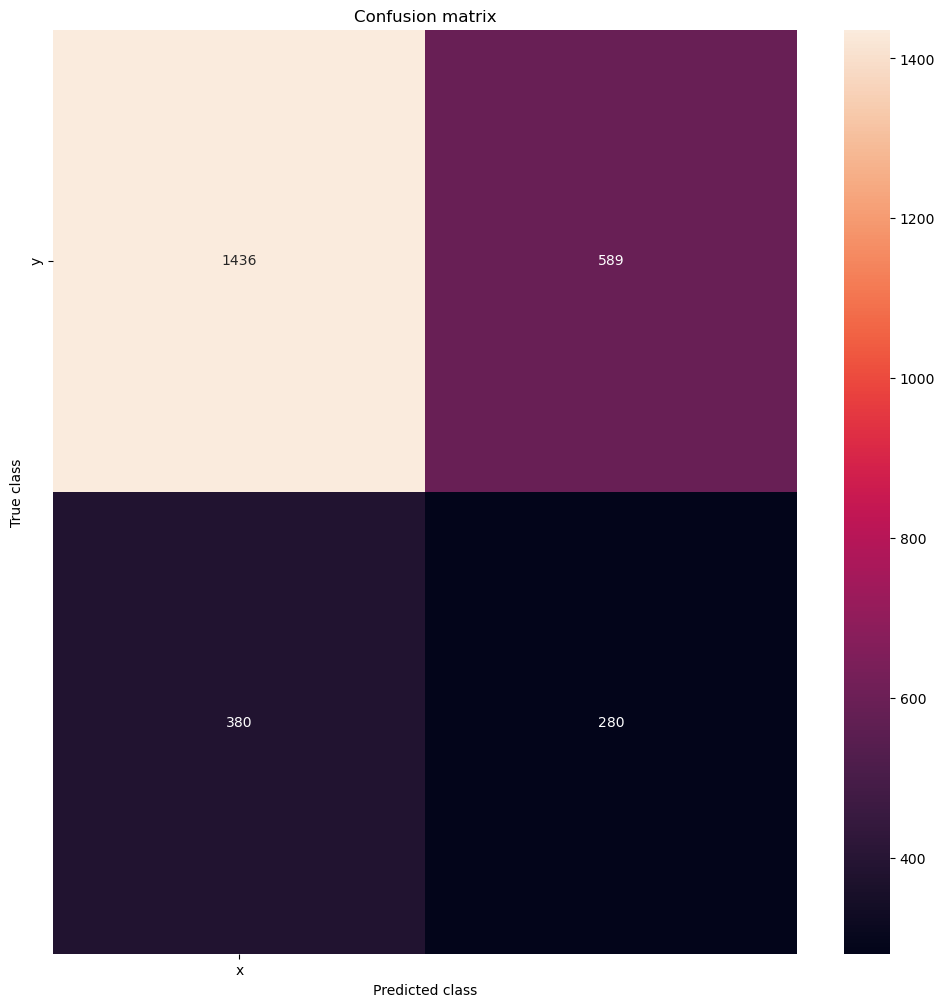

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      2025
           1       0.32      0.42      0.37       660

    accuracy                           0.64      2685
   macro avg       0.56      0.57      0.56      2685
weighted avg       0.68      0.64      0.65      2685

AUC: 0.5666891133557801


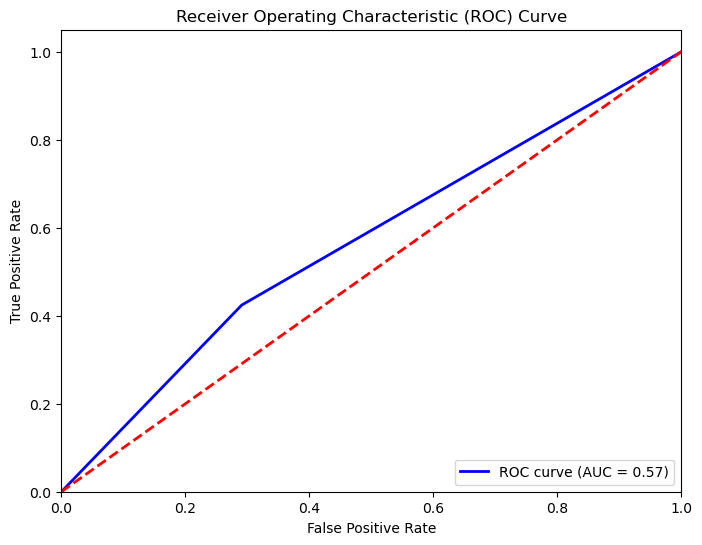

In [9]:
# Metricas con el test
mostrar_resultados2(y_test, y_pred_arbol)

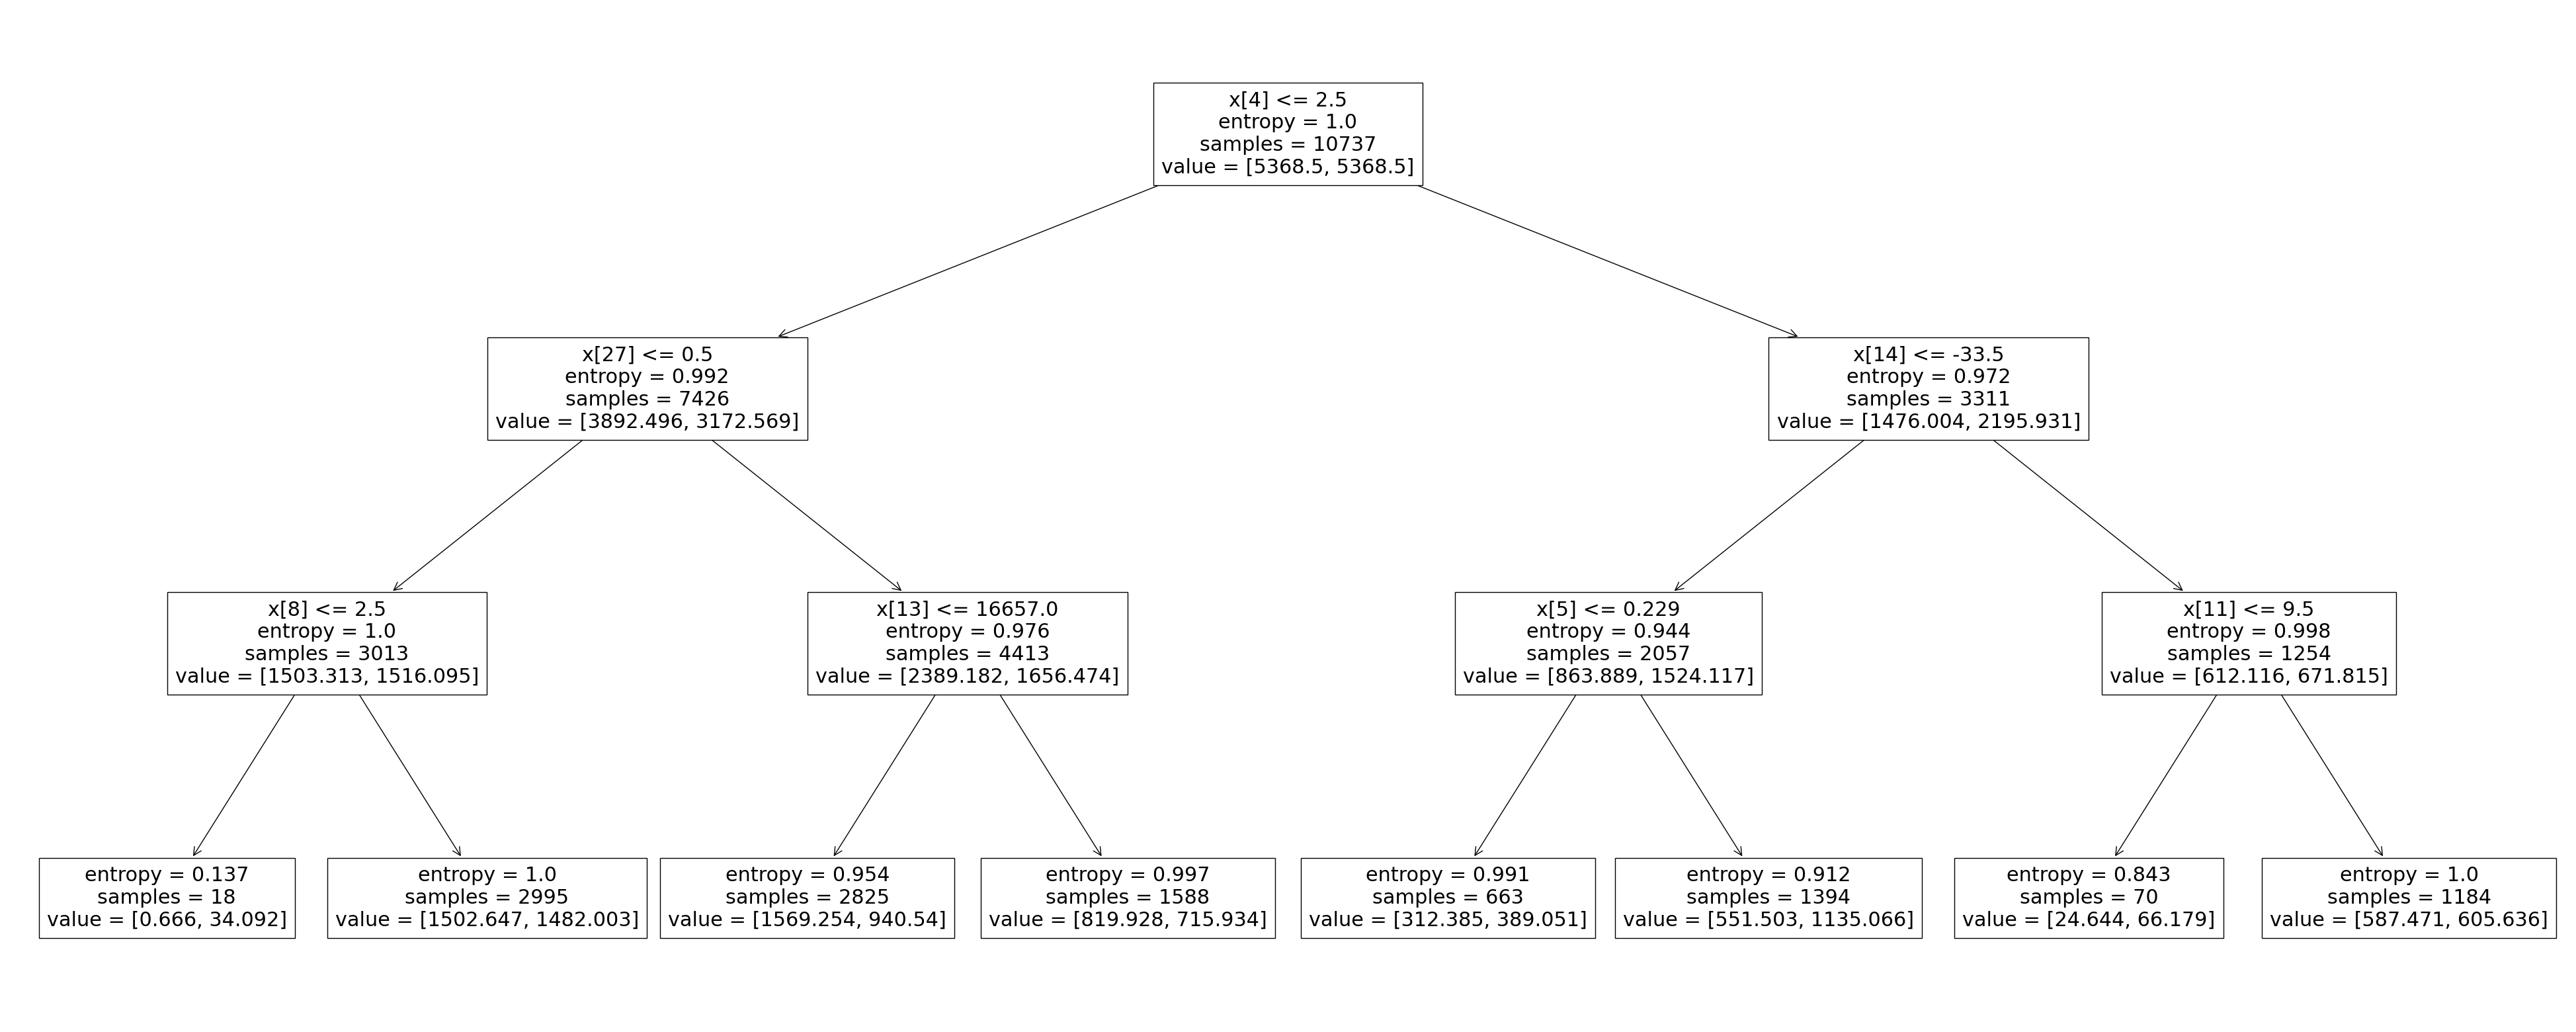

In [12]:
# Grafico
plt.figure(figsize=(50,20))
tree.plot_tree(arbol)
plt.show()

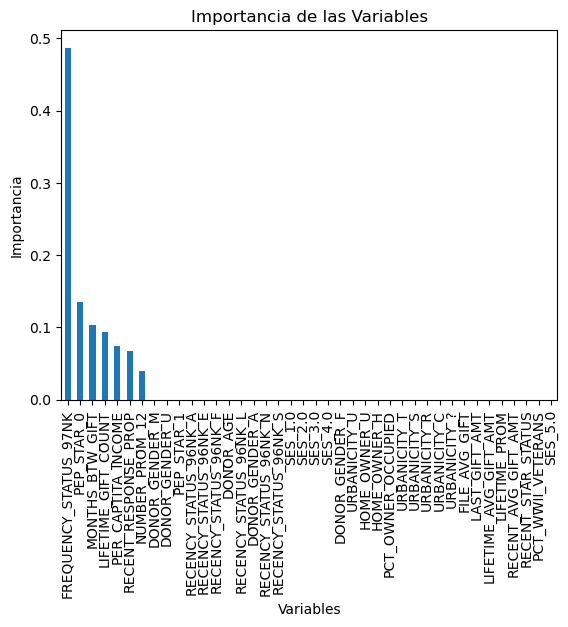

In [13]:
# Importancia de las variables
feature_importances = pd.Series(arbol.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar')

plt.title('Importancia de las Variables')
plt.xlabel('Variables')
plt.ylabel('Importancia')

plt.show()

## 3.2 Regresión Logística

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [15]:
# Definir los parámetros a ajustar
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Inicializar el modelo de regresión logística
lr = LogisticRegression(random_state=42, solver="newton-cg", class_weight="balanced")

# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc')

# Ajustar la búsqueda en cuadrícula a los datos
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_lr = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluar el modelo en el conjunto de prueba
y_pred_proba = best_lr.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)

print("Mejores hiperparámetros:", best_params)
print("AUC en el conjunto de prueba:", auc)

Mejores hiperparámetros: {'C': 0.01, 'penalty': 'l2'}
AUC en el conjunto de prueba: 0.6183812653089165


In [32]:
# Ajustamos el modelo
lr = LogisticRegression(C=0.01,penalty='l2',random_state=42,solver="newton-cg",class_weight="balanced")
lr.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Predicciones
y_pred_lr = best_lr.predict(X_test)

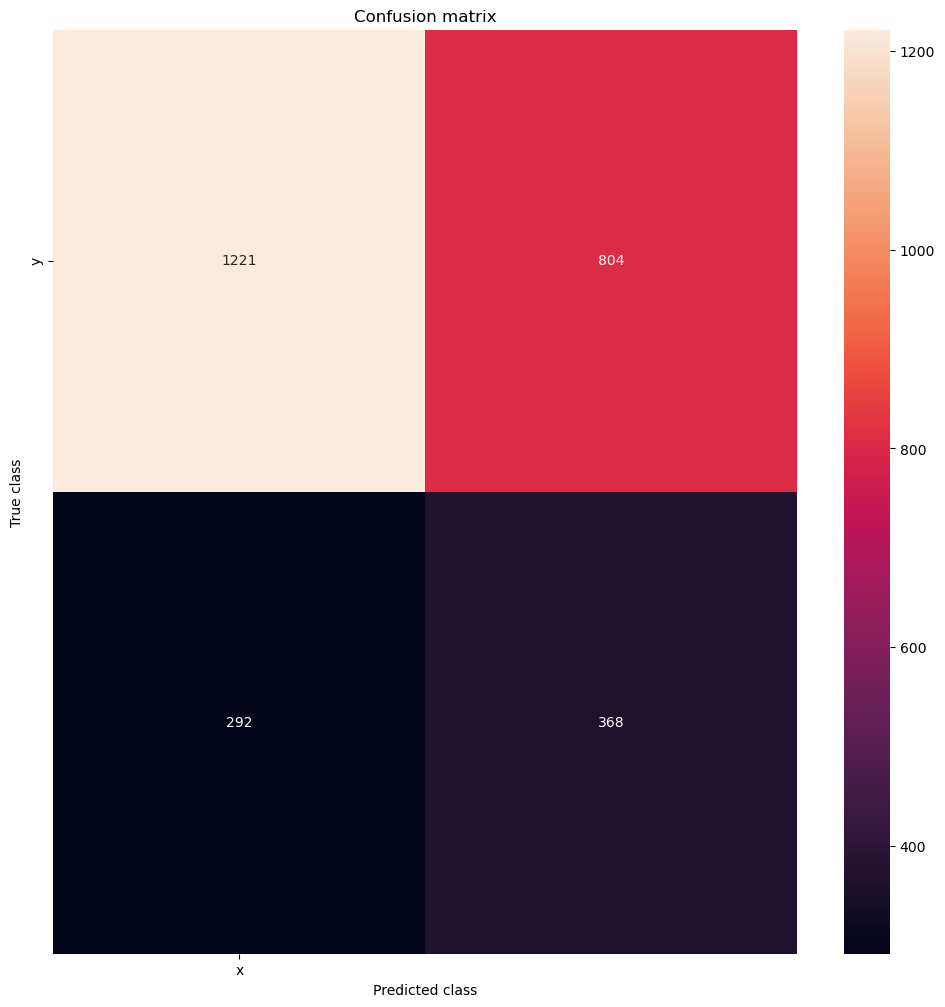

              precision    recall  f1-score   support

           0       0.81      0.60      0.69      2025
           1       0.31      0.56      0.40       660

    accuracy                           0.59      2685
   macro avg       0.56      0.58      0.55      2685
weighted avg       0.69      0.59      0.62      2685

AUC: 0.5802693602693603


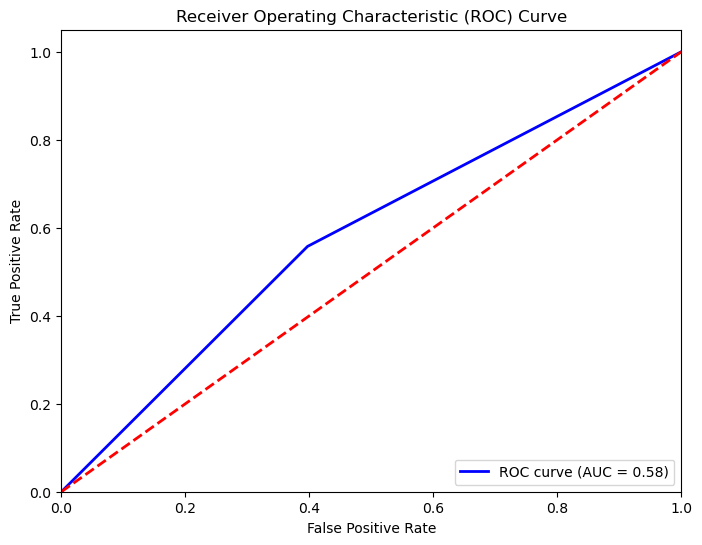

In [33]:
# Calcular y mostrar las métricas
mostrar_resultados2(y_test, y_pred_lr)

## 2.3 Random Forest

Se trata de un modelo de ensamble que combia varios árboles de decisión para hacer predicciones. Así, cada árbol de decisión es entrenado en un subconjunto de los datos de entrenamiento elegido de manera aleatoria, lo que ayuda a reducir el problema de overfitting (o sobreajuste). Las predicciones se realizan teniendo en cuenta la clasificación mayoritaria de las predicciones de cada árbol individual.

Se trata de un tipo específico de método de Bagging, pues además de usar muestras bootstrap de los datos de entrenamiento, cada árbol se entrena en un subconjunto aleatorio de características.

In [34]:
# Librerias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score

En este caso, podemos utilizar técnicas de cross validation para hallar:

* **n_estimators**: Es el número de árboles de decisión para el Random Forest. En general, un mayor número de estimadores mejora el rendimiento del modelo, pero también incrementa el costo computacional para realizar predicciones.
* **max_depth**: Es la profundidad del árbol. Una profundidad alta puede llevar a overfitting, mientras que una profundidad baja puede resultar en underfitting.

Utilizando técnicas de validación cruzada, podemos ajustar estos hiperparámetros y seleccionar los valores óptimos que maximicen el rendimiento del modelo. En este caso, vamos a utilizar la función RandomizedSearch()

In [35]:
# Definir el rango de profundidades y número de árboles
ps = np.array(range(50, 250))  # profundidades
ns = np.array(range(3, 10))    # n árboles

# Definir los hiperparámetros
h_parameters = {'n_estimators': ps, 'max_depth': ns}

# Instanciar el modelo
rf = RandomForestClassifier(class_weight = 'balanced')

# Definir las métricas a utilizar para la búsqueda
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score)}

# Realizar la hiperparametrización
rand_search = RandomizedSearchCV(rf, param_distributions=h_parameters, n_iter=5, cv=5, scoring=scoring, refit='AUC')
rand_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf = rand_search.best_estimator_

# Mostrar los mejores hiperparámetros
print('Mejores hiperparámetros:', rand_search.best_params_)

Mejores hiperparámetros: {'n_estimators': 214, 'max_depth': 4}


Con los parámetros determinados, ajustamos el modelo.

In [36]:
# Ajuste del modelo
rf = RandomForestClassifier(class_weight='balanced', n_estimators = 150, max_depth=4, criterion='entropy', random_state=42)
rf.fit(X_train, y_train)

# Predicciones
y_pred_forest = rf.predict(X_test)

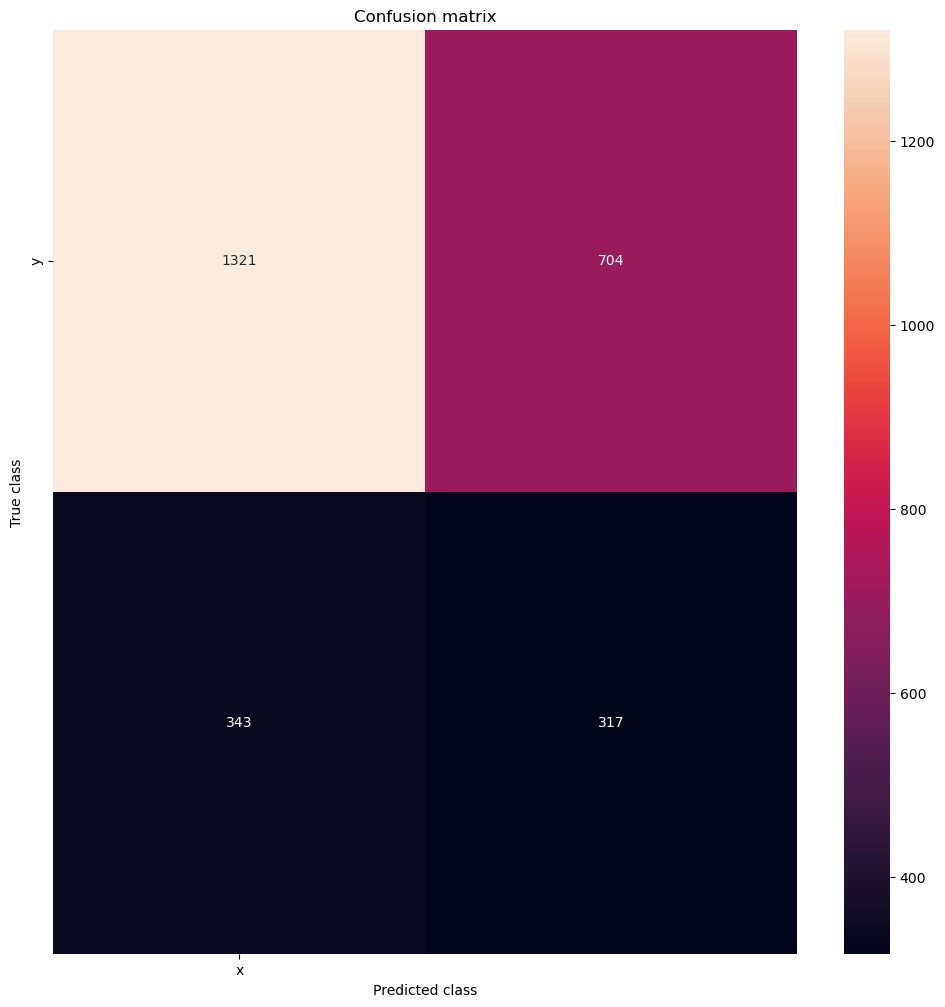

              precision    recall  f1-score   support

           0       0.79      0.65      0.72      2025
           1       0.31      0.48      0.38       660

    accuracy                           0.61      2685
   macro avg       0.55      0.57      0.55      2685
weighted avg       0.68      0.61      0.63      2685

AUC: 0.5663243546576879


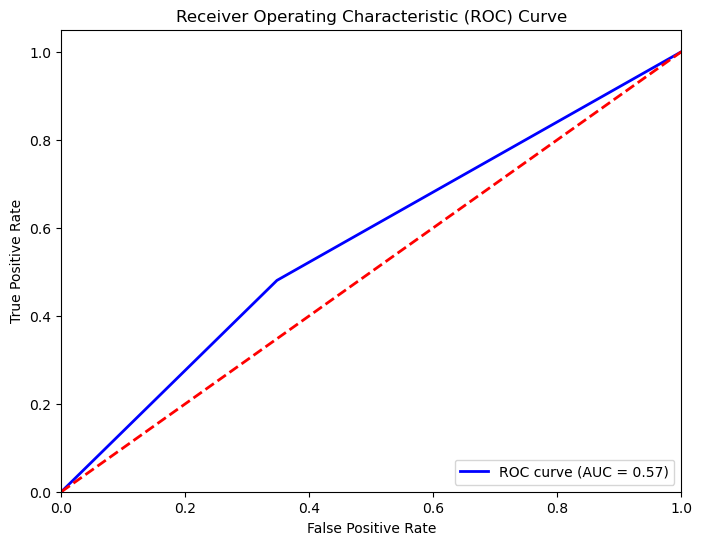

In [37]:
# Calcular y mostrar las métricas
mostrar_resultados2(y_test, y_pred_forest)

## 2.4 Gradient Boosting

Gradient boostig es un algoritmo de machine learning que se basa en la creación de un conjunto de modelos de predicción débiles, generalmente árboles de decisión, que se combinan para formar un modelo de predicción más fuerte. En cada iteración, el algoritmo ajusta los pesos de los modelos débiles para corregir los errores del modelo anterior. Esto se hace mediante la optimización de una función de pérdida diferenciable.

In [ ]:
# Librerias
from sklearn.ensemble import GradientBoostingClassifier

En primer lugar, buscamos los hiperparámetros del modelo de la misma forma que lo hemos hecho para el modelo de Random Forest.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
import numpy as np

# Posibles profundidades y numero de arboles
ps = np.array(range(50, 250))  # profundidades
ns = np.array(range(3, 10))   # n arboles

h_parameters = {'n_estimators': ps, 'max_depth': ns, 'subsample': [0.8, 0.9, 1.0], 'learning_rate': [0.01, 0.1, 0.5, 1.0]}

# Instanciar el modelo
gb = GradientBoostingClassifier()

# Definir las métricas a utilizar para la búsqueda
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score)}

# Realizar la hiperparametrización
rand_search = RandomizedSearchCV(gb, param_distributions=h_parameters, n_iter=5, cv=5, scoring=scoring, refit='AUC')
rand_search.fit(X_train, y_train)

# Optimo
best_gb = rand_search.best_estimator_
print('Mejores hiperparámetros:', rand_search.best_params_)


In [ ]:
best_gb

In [ ]:
# Ajustar el modelo con los datos de entrenamiento
best_gb.fit(X_train, y_train)

# Hacer predicciones en los datos de validación
y_pred_gb = best_gb.predict(X_test)

# Calcular métricas de evaluación
mostrar_resultados2(y_test, y_pred_gb)
